## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from torch.utils.data import Subset
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import time

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
# Класс TinyNeuralNetwork реализует простую нейронную сеть для классификации изображений
class TinyNetModel(nn.Module):
    def __init__(self, input_dim=28*28, output_classes=10, channels=1):
        super(TinyNetModel, self).__init__()
        
        # Определяем архитектуру сети с использованием последовательной модели
        self.flatten_layer = nn.Flatten()  # Преобразование данных в одномерный вектор
        self.hidden_layers = nn.Sequential(
            nn.Linear(input_dim, 300),       # Первый слой, 300 нейронов
            nn.BatchNorm1d(300),            # Нормализация для ускорения обучения
            nn.ReLU(),                      # Активация ReLU
            nn.Dropout(0.5),                # Dropout для предотвращения переобучения
            nn.Linear(300, 100),            # Второй слой, 100 нейронов
            nn.ReLU(),                      # Активация ReLU
            nn.Dropout(0.5),                # Dropout
        )
        self.output_layer = nn.Sequential(
            nn.Linear(100, output_classes), # Выходной слой, число классов = output_classes
            nn.LogSoftmax(dim=1)            # Применение LogSoftmax для логарифма вероятностей
        )

    def forward(self, x):
        # Прямой проход через модель
        x = self.flatten_layer(x)        # Разворачивание входного тензора
        x = self.hidden_layers(x)        # Проход через скрытые слои
        x = self.output_layer(x)         # Преобразование к вероятностному пространству
        return x


In [8]:
# Импорт необходимых библиотек
import torch
import torch.nn as nn
import torchsummary

# Определяем устройство для вычислений (CPU или CUDA, если доступно)
device = torch.device('cpu')  # Устанавливаем устройство явно

# Инициализация и перенос модели на устройство
model = TinyNetModel().to(device)  # TinyNetModel — это класс, определённый ранее

# Использование torchsummary для получения структуры модели
# Передаём размер входных данных (размер тензора) и указываем устройство
torchsummary.summary(model=model, input_size=(28*28,), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 300]         235,500
       BatchNorm1d-3                  [-1, 300]             600
              ReLU-4                  [-1, 300]               0
           Dropout-5                  [-1, 300]               0
            Linear-6                  [-1, 100]          30,100
              ReLU-7                  [-1, 100]               0
           Dropout-8                  [-1, 100]               0
            Linear-9                   [-1, 10]           1,010
       LogSoftmax-10                   [-1, 10]               0
Total params: 267,210
Trainable params: 267,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.02
Estimated T

Your experiments come here:

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

neural_net = TinyNetModel()
# Инициализация оптимизатора Adam с явным указанием параметров
learning_rate = 0.001  # Уровень обучения
optimizer = optim.Adam(params=neural_net.parameters(), lr=learning_rate)

# Определение функции ошибки (потерь) для многоклассовой классификации
loss_function = nn.CrossEntropyLoss()  # Кросс-энтропия для задачи классификации

# Train Function

In [10]:
from tqdm import tqdm  # Для отображения прогресса

# Определение функции для подсчёта точности
def calculate_accuracy(predictions, targets):
    """ Функция для вычисления точности предсказаний """
    predicted_classes = torch.max(predictions, 1)[1]
    correct = (predicted_classes == targets).sum().item()
    accuracy = 100 * correct / len(targets)
    return accuracy

# Определение функции для вычисления потерь
def calculate_loss(predictions, targets, criterion):
    """ Подсчёт функции потерь """
    loss = criterion(predictions, targets)
    return loss.item()


# Логирование метрик
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

# Основной цикл обучения
for epoch in range(1, 21):  # Обучение
    print(f"--- Эпоха {epoch} ---")
    
    train_epoch_losses, test_epoch_losses = [], []
    train_epoch_accuracies, test_epoch_accuracies = [], []

    # Обучение модели
    neural_net.train()
    for images, labels in tqdm(train_loader, desc=f"Обучение (эпоха {epoch})"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = neural_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_epoch_losses.append(loss.item())
        train_epoch_accuracies.append(calculate_accuracy(outputs, labels))

    # Оценка модели
    neural_net.eval()
    with torch.no_grad():
        total_correct, total_samples = 0, 0
        for images, labels in tqdm(test_loader, desc=f"Тестирование (эпоха {epoch})"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = neural_net(images)
            loss = calculate_loss(outputs, labels, loss_function)
            test_epoch_losses.append(loss)
            
            predictions = torch.max(outputs, 1)[1]
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)
        
        test_accuracy = 100 * total_correct / total_samples

    # Логируем метрики для одной эпохи
    train_losses.append(np.mean(train_epoch_losses))
    test_losses.append(np.mean(test_epoch_losses))
    train_accuracies.append(np.mean(train_epoch_accuracies))
    test_accuracies.append(test_accuracy)

    print(f"Эпоха: {epoch} | Потеря (тест): {test_losses[-1]:.4f} | Точность (тест): {test_accuracy:.2f}%")


--- Эпоха 1 ---


Тестирование (эпоха 1): 100%|██████████| 40/40 [00:03<00:00, 12.68it/s]


Эпоха: 1 | Потеря (тест): 0.4186 | Точность (тест): 84.56%
--- Эпоха 2 ---


Тестирование (эпоха 2): 100%|██████████| 40/40 [00:03<00:00, 13.13it/s]


Эпоха: 2 | Потеря (тест): 0.3914 | Точность (тест): 85.47%
--- Эпоха 3 ---


Тестирование (эпоха 3): 100%|██████████| 40/40 [00:03<00:00, 12.99it/s]


Эпоха: 3 | Потеря (тест): 0.3748 | Точность (тест): 86.06%
--- Эпоха 4 ---


Тестирование (эпоха 4): 100%|██████████| 40/40 [00:03<00:00, 12.82it/s]


Эпоха: 4 | Потеря (тест): 0.3683 | Точность (тест): 86.33%
--- Эпоха 5 ---


Тестирование (эпоха 5): 100%|██████████| 40/40 [00:03<00:00, 12.86it/s]


Эпоха: 5 | Потеря (тест): 0.3536 | Точность (тест): 86.95%
--- Эпоха 6 ---


Тестирование (эпоха 6): 100%|██████████| 40/40 [00:03<00:00, 12.53it/s]


Эпоха: 6 | Потеря (тест): 0.3519 | Точность (тест): 87.09%
--- Эпоха 7 ---


Тестирование (эпоха 7): 100%|██████████| 40/40 [00:03<00:00, 12.88it/s]


Эпоха: 7 | Потеря (тест): 0.3537 | Точность (тест): 86.97%
--- Эпоха 8 ---


Тестирование (эпоха 8): 100%|██████████| 40/40 [00:03<00:00, 12.70it/s]


Эпоха: 8 | Потеря (тест): 0.3359 | Точность (тест): 87.67%
--- Эпоха 9 ---


Тестирование (эпоха 9): 100%|██████████| 40/40 [00:03<00:00, 12.73it/s]


Эпоха: 9 | Потеря (тест): 0.3409 | Точность (тест): 87.45%
--- Эпоха 10 ---


Тестирование (эпоха 10): 100%|██████████| 40/40 [00:03<00:00, 12.81it/s]


Эпоха: 10 | Потеря (тест): 0.3336 | Точность (тест): 87.77%
--- Эпоха 11 ---


Тестирование (эпоха 11): 100%|██████████| 40/40 [00:03<00:00, 12.53it/s]


Эпоха: 11 | Потеря (тест): 0.3316 | Точность (тест): 87.75%
--- Эпоха 12 ---


Тестирование (эпоха 12): 100%|██████████| 40/40 [00:03<00:00, 10.34it/s]


Эпоха: 12 | Потеря (тест): 0.3362 | Точность (тест): 87.71%
--- Эпоха 13 ---


Тестирование (эпоха 13): 100%|██████████| 40/40 [00:03<00:00, 12.08it/s]


Эпоха: 13 | Потеря (тест): 0.3213 | Точность (тест): 88.08%
--- Эпоха 14 ---


Тестирование (эпоха 14): 100%|██████████| 40/40 [00:03<00:00, 12.73it/s]


Эпоха: 14 | Потеря (тест): 0.3214 | Точность (тест): 88.36%
--- Эпоха 15 ---


Тестирование (эпоха 15): 100%|██████████| 40/40 [00:03<00:00, 12.83it/s]


Эпоха: 15 | Потеря (тест): 0.3134 | Точность (тест): 88.51%
--- Эпоха 16 ---


Тестирование (эпоха 16): 100%|██████████| 40/40 [00:03<00:00, 12.09it/s]


Эпоха: 16 | Потеря (тест): 0.3169 | Точность (тест): 88.05%
--- Эпоха 17 ---


Тестирование (эпоха 17): 100%|██████████| 40/40 [00:03<00:00, 10.16it/s]


Эпоха: 17 | Потеря (тест): 0.3163 | Точность (тест): 87.91%
--- Эпоха 18 ---


Тестирование (эпоха 18): 100%|██████████| 40/40 [00:03<00:00, 12.28it/s]


Эпоха: 18 | Потеря (тест): 0.3172 | Точность (тест): 88.39%
--- Эпоха 19 ---


Тестирование (эпоха 19): 100%|██████████| 40/40 [00:03<00:00, 12.92it/s]

Эпоха: 19 | Потеря (тест): 0.3144 | Точность (тест): 88.57%


# Visuals

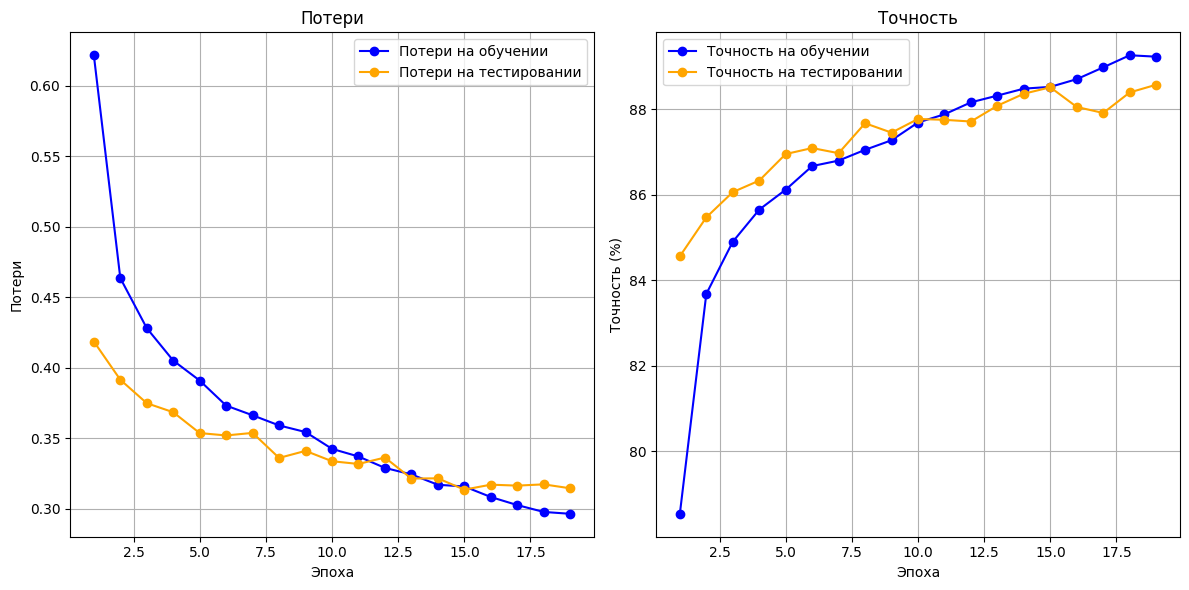

In [11]:
import matplotlib.pyplot as plt

def visualize_training_process(train_losses, test_losses, train_accuracies, test_accuracies):
    """ 
    Визуализация потерь и точности для процесса обучения.
    
    Параметры:
    - train_losses: потери на обучении для каждой эпохи
    - test_losses: потери на тестировании для каждой эпохи
    - train_accuracies: точность на обучении для каждой эпохи
    - test_accuracies: точность на тестировании для каждой эпохи
    - version: текст, указывающий, какая это версия (для заголовка графиков)
    """
    
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 6))
    
    # Визуализация потерь (loss)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Потери на обучении', marker='o', color='blue')
    plt.plot(epochs, test_losses, label='Потери на тестировании', marker='o', color='orange')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.title(f'Потери')
    plt.legend()
    plt.grid(True)
    
    # Визуализация точности (accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Точность на обучении', marker='o', color='blue')
    plt.plot(epochs, test_accuracies, label='Точность на тестировании', marker='o', color='orange')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность (%)')
    plt.title(f'Точность')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Вызов функции для визуализации первой версии
visualize_training_process(train_losses, test_losses, train_accuracies, test_accuracies)


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time  # Для замера времени

# Определяем устройство для вычислений: если доступна CUDA, используем её
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Определяем класс нейросети OverfittingNeuralNetwork
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10):
        """ 
        Конструктор для создания структуры нейросети 
        Аргументы:
        - input_shape: размерность входных данных (по умолчанию 28x28 для изображений)
        - num_classes: количество классов для классификации (по умолчанию 10) 
        """
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),  # Преобразование двумерного изображения в вектор
            nn.Linear(input_shape, 392),  # Полносвязный скрытый слой с 392 нейронами
            nn.ReLU(),  # Активационная функция ReLU
            nn.Linear(392, num_classes),  # Выходной слой
            nn.LogSoftmax(dim=1)  # Применение логарифмического Softmax для вероятностей
        )
        
    def forward(self, x):
        """ Прямое распространение данных через модель """
        return self.model(x)

# Отображение информации о структуре модели
from torchsummary import summary
summary(OverfittingNeuralNetwork().to(device), (28*28,))

# Инициализация модели, оптимизатора и функции потерь
model = OverfittingNeuralNetwork().to(device)  # Отправляем модель на устройство (CPU или GPU)
opt = optim.Adam(model.parameters(), lr=1e-3)  # Используем Adam с шагом обучения 0.001
loss_func = nn.CrossEntropyLoss()  # Функция потерь кросс-энтропии для задач классификации

# Функция для обучения модели
def train_model(model, train_loader, val_loader, loss_fn, optimizer, n_epochs: int):
    """
    Функция для обучения модели.
    Аргументы:
    - model: обучаемая модель
    - train_loader: загрузчик данных для обучения
    - val_loader: загрузчик данных для проверки
    - loss_fn: функция потерь
    - optimizer: оптимизатор
    - n_epochs: количество эпох для обучения
    """
    train_losses = []  # Список для записи потерь на обучающей выборке
    val_losses = []  # Список для записи потерь на валидационной выборке
    val_accuracies = []  # Список для записи точности на валидационной выборке
    
    for epoch in range(n_epochs):  # Основной цикл по эпохам
        train_epoch_losses = []  # Потери за одну эпоху на обучении
        val_epoch_losses = []  # Потери за одну эпоху на проверке
        val_epoch_accuracies = []  # Точность за одну эпоху на проверке
        start_time = time.time()  # Замер времени начала эпохи

        # --- Обучение ---
        model.train()  # Переводим модель в режим обучения
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Перемещение тензоров на устройство (CPU или GPU)
            
            optimizer.zero_grad()  # Обнуляем градиенты
            predictions = model(X_batch)  # Прямое распространение (forward pass)
            loss = loss_fn(predictions, y_batch)  # Подсчёт функции потерь
            loss.backward()  # Обратное распространение (backpropagation)
            optimizer.step()  # Обновление параметров модели

            train_epoch_losses.append(loss.item())  # Логируем значение потерь за один батч

        # --- Проверка ---
        model.eval()  # Переводим модель в режим оценки
        with torch.no_grad():  # Отключаем вычисление градиентов
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Перемещение тензоров на устройство
                predictions = model(X_batch)  # Прямое распространение
                loss = loss_fn(predictions, y_batch)  # Подсчёт функции потерь
                val_epoch_losses.append(loss.item())  # Логируем потери на проверочной выборке

                y_pred = predictions.argmax(dim=1)  # Предсказание метки класса
                accuracy = (y_pred == y_batch).float().mean().item()  # Подсчёт точности
                val_epoch_accuracies.append(accuracy)  # Логируем точность

        # Логирование потерь и точности по эпохам
        train_losses.append(np.mean(train_epoch_losses))  # Средние потери за эпоху (обучение)
        val_losses.append(np.mean(val_epoch_losses))  # Средние потери за эпоху (валидация)
        val_accuracies.append(np.mean(val_epoch_accuracies))  # Средняя точность за эпоху (валидация)

        epoch_time = time.time() - start_time  # Время, затраченное на эпоху
        print(f"Эпоха {epoch+1}/{n_epochs} | Потери на обучении: {train_losses[-1]:.4f} | Потери на проверке: {val_losses[-1]:.4f} | Точность: {val_accuracies[-1]:.2f}% | Время: {epoch_time:.2f} сек")

    return train_losses, val_losses, val_accuracies


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 392]         307,720
              ReLU-3                  [-1, 392]               0
            Linear-4                   [-1, 10]           3,930
        LogSoftmax-5                   [-1, 10]               0
Total params: 311,650
Trainable params: 311,650
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.19
Estimated Total Size (MB): 1.20
----------------------------------------------------------------


## Уменьшим датасет

In [21]:
def subset_ind(dataset, ratio: float):
    return np.random.choice(len(dataset), size=int(ratio*len(dataset)), replace=False)

val_size = 0.1
val_inds = subset_ind(fmnist_dataset_train, val_size)

train_dataset = Subset(fmnist_dataset_train, val_inds)

len(train_dataset)

6000

In [22]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

In [23]:
# Train the model
n_epochs = 75
train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

Эпоха 1/75 | Потери на обучении: 1.0066 | Потери на проверке: 0.7050 | Точность: 0.75% | Время: 6.19 сек
Эпоха 2/75 | Потери на обучении: 0.6259 | Потери на проверке: 0.5919 | Точность: 0.80% | Время: 5.99 сек
Эпоха 3/75 | Потери на обучении: 0.5296 | Потери на проверке: 0.5574 | Точность: 0.80% | Время: 7.35 сек
Эпоха 4/75 | Потери на обучении: 0.4777 | Потери на проверке: 0.5164 | Точность: 0.82% | Время: 7.13 сек
Эпоха 5/75 | Потери на обучении: 0.4500 | Потери на проверке: 0.5085 | Точность: 0.82% | Время: 6.30 сек
Эпоха 6/75 | Потери на обучении: 0.4205 | Потери на проверке: 0.4728 | Точность: 0.83% | Время: 7.03 сек
Эпоха 7/75 | Потери на обучении: 0.4029 | Потери на проверке: 0.4856 | Точность: 0.82% | Время: 6.63 сек
Эпоха 8/75 | Потери на обучении: 0.3796 | Потери на проверке: 0.4684 | Точность: 0.84% | Время: 6.60 сек
Эпоха 9/75 | Потери на обучении: 0.3640 | Потери на проверке: 0.4688 | Точность: 0.83% | Время: 6.70 сек
Эпоха 10/75 | Потери на обучении: 0.3460 | Потери на пр

In [28]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)
    

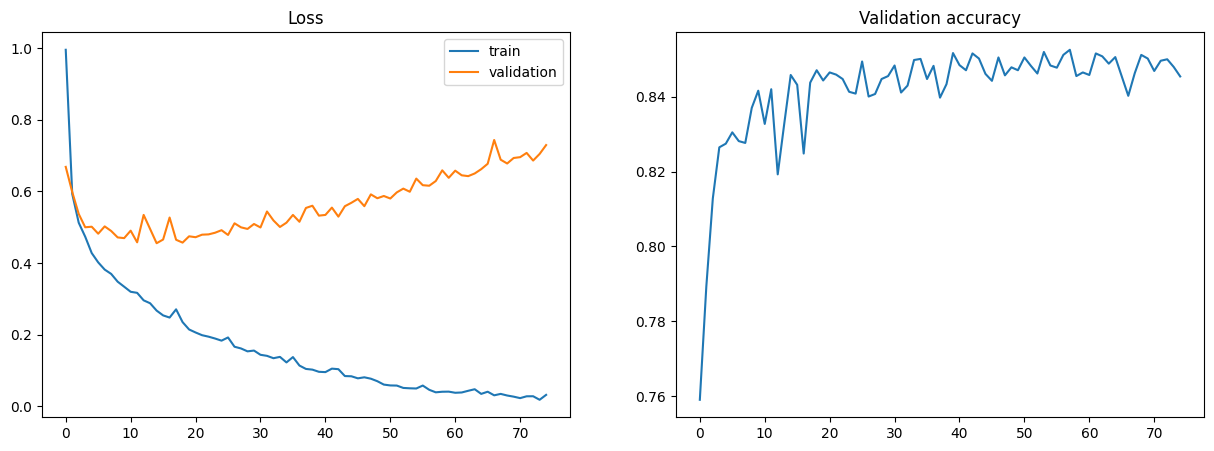

In [29]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [30]:
import torch.nn as nn

class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(), 
            nn.Dropout(p=0.5),  
            nn.Linear(784, 392),  
            nn.ReLU(),  
            nn.Dropout(p=0.5),  
            nn.Linear(392, num_classes),  
            nn.LogSoftmax(dim=1) 
        )
        
    def forward(self, inp):
        out = self.model(inp)
        return out

In [31]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                  [-1, 392]         307,720
              ReLU-4                  [-1, 392]               0
           Dropout-5                  [-1, 392]               0
            Linear-6                   [-1, 10]           3,930
        LogSoftmax-7                   [-1, 10]               0
Total params: 311,650
Trainable params: 311,650
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.19
Estimated Total Size (MB): 1.21
----------------------------------------------------------------


In [32]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

In [33]:
n_epochs = 75

train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

Epoch 1/75, Train Loss: 1.2001, Val Loss: 0.7651, Val Accuracy: 0.7271, Time: 5.92s
Epoch 2/75, Train Loss: 0.7599, Val Loss: 0.6451, Val Accuracy: 0.7671, Time: 6.60s
Epoch 3/75, Train Loss: 0.6826, Val Loss: 0.6015, Val Accuracy: 0.7737, Time: 6.05s
Epoch 4/75, Train Loss: 0.6499, Val Loss: 0.5711, Val Accuracy: 0.7920, Time: 6.08s
Epoch 5/75, Train Loss: 0.6162, Val Loss: 0.5694, Val Accuracy: 0.7959, Time: 6.24s
Epoch 6/75, Train Loss: 0.5978, Val Loss: 0.5310, Val Accuracy: 0.8078, Time: 6.01s
Epoch 7/75, Train Loss: 0.5815, Val Loss: 0.5272, Val Accuracy: 0.8115, Time: 5.97s
Epoch 8/75, Train Loss: 0.5597, Val Loss: 0.5146, Val Accuracy: 0.8188, Time: 5.59s
Epoch 9/75, Train Loss: 0.5492, Val Loss: 0.5181, Val Accuracy: 0.8115, Time: 5.58s
Epoch 10/75, Train Loss: 0.5319, Val Loss: 0.5018, Val Accuracy: 0.8141, Time: 5.60s
Epoch 11/75, Train Loss: 0.5365, Val Loss: 0.4984, Val Accuracy: 0.8252, Time: 5.61s
Epoch 12/75, Train Loss: 0.5099, Val Loss: 0.4826, Val Accuracy: 0.8293, T

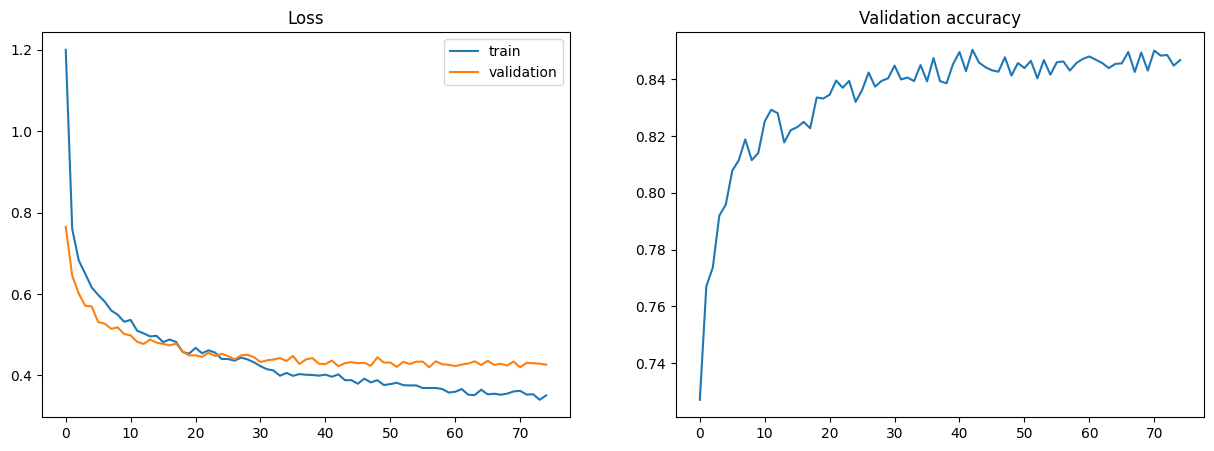

In [34]:
plot_train_process(train_loss, val_loss, val_accuracy)

### Conclusions:
Благодаря добавлению dropout мы смогли починить нашу проблему с переобученем 